### Phase fraction uncertainty quantification

For a given phase, define the normalized intensities as

$$Z_i = I_i / R_i$$

For now, we'll assume the $R_i$ are known completely while we figure out how to implement them efficiently in GSAS. (Either way this is likely a small component of uncertainty relative to the experimental variability of the $I_i$'s.)

There is uncertainty in the $I_i$'s both due to experimental set up as well as the fitting procedure. We'll assume these sources of uncertainty are independent, and thus additive. Thus we model

$$
I_i \sim N(\mu_I, \sigma_{I,exp}^2 + \sigma_{fit_i}^2)
$$

and so 

$$
Z_i \sim N\big(\mu_z, \sigma_{Z,exp}^2 + \frac{\sigma_{fit_i}^2}{R_i^{2}} \big)
$$

$\sigma^2_{fit_i}$ will be assumed known from the fitting procedure, while $\sigma^2_{Z,exp}$ will have to be estimated from data. Since we won't estimate $\mu_I$ and $\sigma^2_{I,exp}$ directly, we will simply denote $\mu_Z$ and $\sigma_Z$ as $\mu$ and $\sigma$ respectively.

In the Bayesian framework, we can write

\begin{align}
p(\mu, \sigma^2_{exp} | Z_i) &\propto p(Z_i|\mu, \sigma^2_{exp}) p(\mu, \sigma^2_{exp}) \\
&= N(Z_i,\mu,\sigma^2_{exp} + R_i^{-2}\sigma^2_{fit}) p(\mu,\sigma^2_{exp})
\end{align}

where the prior distributions will be a standard choice such as a truncated $t_4$ scaled to the MAD. 

Estimation for the other phases will follow similarly.

### Example

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
import pymc3 as pm
from scipy.stats import median_abs_deviation as mad
import plotly.express as px
import seaborn as sns
from scipy.stats import invgamma, t
from scipy.linalg import sqrtm
from statsmodels.stats.meta_analysis import combine_effects
import time


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
print(az.__version__)
print(pm.__version__)

0.11.2
3.6


In [3]:
indata = pd.read_csv('intensity_table.csv')

In [4]:
#indata.head()

In [5]:
mydf = pd.DataFrame({
    'I':indata.int_fit,
    'R':indata.R_calc,
    'sigma_I':indata.u_int_fit,
    'phases':indata.Phase,
    'two_th':indata.two_theta
})

mydf['IR'] = mydf.I / mydf.R
mydf['sig_IR'] = mydf['sigma_I']/mydf.R

mydf = mydf.sort_values('phases').reset_index(drop=True)

In [6]:
print(mydf)

            I           R  sigma_I                phases   two_th        IR  \
0   21716.194  261157.488  168.301  austenite-SRM487.cif   43.593  0.083154   
1    7812.145  122379.402  123.253  austenite-SRM487.cif   50.777  0.063835   
2    4734.357   70554.804  103.257  austenite-SRM487.cif   74.651  0.067102   
3    4864.974   80763.209  110.421  austenite-SRM487.cif   90.633  0.060238   
4    1368.346   23555.357   80.239  austenite-SRM487.cif   95.910  0.058091   
5      92.318   13186.997   47.393  austenite-SRM487.cif  118.074  0.007001   
6   62590.189  188543.096  258.280    ferrite-SRM487.cif   44.575  0.331968   
7    7283.611   29667.204  113.272    ferrite-SRM487.cif   64.871  0.245511   
8   17954.038   58818.348  152.070    ferrite-SRM487.cif   82.127  0.305246   
9    5211.789   19287.603   98.365    ferrite-SRM487.cif   98.667  0.270214   
10   7830.424   32124.524  122.684    ferrite-SRM487.cif  116.249  0.243752   

      sig_IR  
0   0.000644  
1   0.001007  
2   0.

<AxesSubplot:xlabel='two_th', ylabel='IR'>

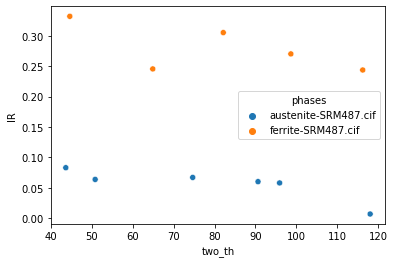

In [7]:
sns.scatterplot(data=mydf,x='two_th',y='IR',hue='phases')

In [8]:
# conjugate priors
def gen_mu_sigma(x,n_draws):
    
    # p(mu,simga) \prop_to 1/sigma OR uniform prior on mu, log(sigma)
    # BDA pg: 66
    
    x_var = np.var(x)
    n_x = x.shape[0]
    v = n_x-1
    tau2 = x_var
    
    sigma2 = invgamma.rvs(a=v/2,scale=v*tau2/2,size=n_draws)
    mu = t.rvs(df=n_x-1, loc=np.mean(x), scale=np.sqrt(x_var/n_x), size=n_draws)
    
    while np.sum(mu < 0) > 0:
        mu[mu < 0] = t.rvs(df=n_x-1, loc=np.mean(x), scale=np.sqrt(x_var/n_x), size=len(mu[mu < 0]))
    
    return mu, sigma2

def get_posterior_samples_cp(I,R,sigma_I,phases,n_draws):

    I = np.array(I)
    R = np.array(R)
    sigma_I = np.array(sigma_I)
    phases = np.array(phases)

    Z = I/R
    unique_phase_names = np.unique(phases)

    res_dict = {}

    for ii in range(len(unique_phase_names)):

        res_dict[unique_phase_names[ii]] = gen_mu_sigma(Z[phases==unique_phase_names[ii]],n_draws)

    return res_dict
    
    

In [9]:
def run_mcmc(I,R,sigma_I,phases,pfs,plot=False):

    I = np.array(I)[pfs]
    R = np.array(R)[pfs]
    sigma_I = np.array(sigma_I)[pfs]
    phases = np.array(phases)[pfs]

    phase_counts = np.unique(phases, return_counts=True)[1]

    if np.min(phase_counts) <= 2:
        print("Phases with fewer than 2 observations present.")
        return None

    phase_names = phases.copy()

    Z = I/R
    unique_phase_names = np.unique(phase_names)

    phases = np.zeros(len(phases),dtype=np.int8)
    
    # create numeric index for each phase
    for ii in range(len(unique_phase_names)):

        phases[phase_names==unique_phase_names[ii]] = int(ii)

    unique_phases = np.unique(phases)
    phase_stds = np.zeros(len(unique_phases))

    # standard deviations for each phase
    for ii in range(len(unique_phases)):

        phase_stds[ii] = np.std(Z[phases==unique_phases[ii]])

    # prior scale and means
    prior_scale=np.mean(phase_stds)
    prior_mean_centers = np.ones(len(unique_phases))

    #print(prior_scale)
    #print(prior_mean_centers)   

    if plot:
        plt.scatter(x=np.arange(len(Z)),y=Z,c=phases)
        print("Z: {}".format(Z))
        print("phases: {}".format(phases))

    basic_model = pm.Model() 

    with basic_model:
        
        # Priors for unknown model parameters
        sigma_exp = pm.HalfStudentT("sigma_exp", sd=prior_scale*2, nu=4,shape=len(unique_phases))
        mu = pm.TruncatedNormal("mu", 
                       mu=prior_mean_centers, 
                       sd=np.std(Z)*10,
                       lower=0,
                       shape=len(unique_phases))
        
        full_sigma = pm.math.sqrt( (1/R**2)*(sigma_I**2) + pm.math.sqr(sigma_exp[phases]) )

        # Likelihood (sampling distribution) of observations
        Y_obs = pm.Normal("Y_obs", mu=mu[phases], sd=full_sigma, observed=Z)

        trace = pm.sample(1000, return_inferencedata=False,tune=1000,cores=None,chains=None)
        
        mu_norm = np.apply_along_axis(lambda x: x/np.sum(x),1,trace['mu'])
        
        mu_df = pd.DataFrame(mu_norm,columns=unique_phase_names)
        mu_df = pd.melt(mu_df,value_vars = unique_phase_names,var_name='which_phase',value_name='value')
        

    summary_table = pd.DataFrame({
        'phase':unique_phase_names,
        'PF_Est':np.zeros(len(unique_phase_names)),
        'PF_L95':np.zeros(len(unique_phase_names)),
        'PF_U95':np.zeros(len(unique_phase_names))
    })

    for ii, pn in enumerate(unique_phase_names):

        quantiles = np.quantile(mu_df['value'].loc[mu_df['which_phase']==pn],[.5,.025,.975])
        summary_table.loc[summary_table['phase'] == pn, ['PF_Est','PF_L95','PF_U95']] = quantiles

    return {'mu_df':mu_df,'trace':trace,
            'unique_phase_names':unique_phase_names,
            'summary_table':summary_table}

In [10]:
mydf.phases

0     austenite-SRM487.cif
1     austenite-SRM487.cif
2     austenite-SRM487.cif
3     austenite-SRM487.cif
4     austenite-SRM487.cif
5     austenite-SRM487.cif
6       ferrite-SRM487.cif
7       ferrite-SRM487.cif
8       ferrite-SRM487.cif
9       ferrite-SRM487.cif
10      ferrite-SRM487.cif
Name: phases, dtype: object

Z: [0.08315363 0.06383546 0.06710184 0.0602375  0.05809065 0.00700068
 0.33196755 0.24551053 0.30524553 0.27021445 0.24375222]
phases: [0 0 0 0 0 0 1 1 1 1 1]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma_exp]
Sampling 4 chains: 100%|██████████████████████████████████████████████████████| 8000/8000 [00:05<00:00, 1574.19draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6856490652806753, but should be close to 0.8. Try to increase the number of tuning steps.


40.25115132331848


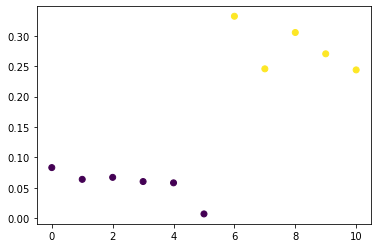

In [11]:
start = time.time()
res = run_mcmc(mydf.I,mydf.R,mydf.sigma_I,mydf.phases,np.array([True]*len(mydf.phases)),plot=True)
end = time.time()
print(end - start)

In [19]:
apf = res['mu_df'].value[res['mu_df'].which_phase == 'ferrite-SRM487.cif']

In [20]:
res['trace']['mu'].shape

(4000, 2)

In [21]:
np.quantile(apf,[.025,.25,.5,.75,.975])

array([0.75425795, 0.80959822, 0.83137977, 0.85349046, 0.90672834])

<AxesSubplot:xlabel='value', ylabel='Count'>

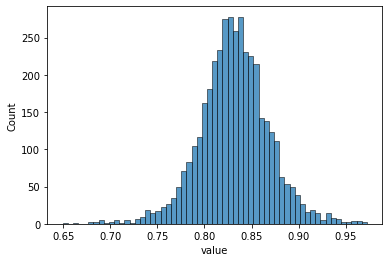

In [22]:
sns.histplot(x=apf)

### Multiple Datasets

In [3]:
indata = pd.read_csv('intensity_table.csv')

In [4]:
mydf = pd.DataFrame({
    'I':indata.int_fit,
    'R':indata.R_calc,
    'sigma_I':indata.u_int_fit,
    'phases':indata.Phase,
    'two_th':indata.two_theta
})

mydf['IR'] = mydf.I / mydf.R
mydf['sig_IR'] = mydf['sigma_I']/mydf.R

mydf = mydf.sort_values('phases').reset_index(drop=True)

In [5]:
multiple_df = pd.concat((mydf.copy(),mydf.copy(),mydf.copy())).reset_index(drop=True)

In [6]:
multiple_df['sample_id'] = np.repeat((0,1,2),11)

In [10]:
np.random.seed(123)

In [11]:
for ii in range(3):
    multiple_df.loc[multiple_df['sample_id']==ii,'I'] = multiple_df['I'].loc[multiple_df['sample_id']==ii]*(1+ii/2)
    
multiple_df['I'] = multiple_df['I'] + np.random.normal(0,multiple_df['I']/10,multiple_df.shape[0])
multiple_df['IR'] = multiple_df['I']/multiple_df['R']

In [40]:
multiple_df

,I,R,sigma_I,phases,two_th,IR,sig_IR,sample_id
0,19106.409978,261157.488,168.301,austenite-SRM487.cif,43.593,0.073160,0.000644,0
1,6977.054213,122379.402,123.253,austenite-SRM487.cif,50.777,0.057012,0.001007,0
2,3741.333244,70554.804,103.257,austenite-SRM487.cif,74.651,0.053027,0.001464,0
3,4021.310566,80763.209,110.421,austenite-SRM487.cif,90.633,0.049791,0.001367,0
4,1304.384150,23555.357,80.239,austenite-SRM487.cif,95.910,0.055375,0.003406,0
5,107.248019,13186.997,47.393,austenite-SRM487.cif,118.074,0.008133,0.003594,0
6,50553.218664,188543.096,258.280,ferrite-SRM487.cif,44.575,0.268126,0.001370,0
7,6283.580636,29667.204,113.272,ferrite-SRM487.cif,64.871,0.211802,0.003818,0
8,21415.720763,58818.348,152.070,ferrite-SRM487.cif,82.127,0.364099,0.002585,0
9,5150.655271,19287.603,98.365,ferrite-SRM487.cif,98.667,0.267045,0.005100,0


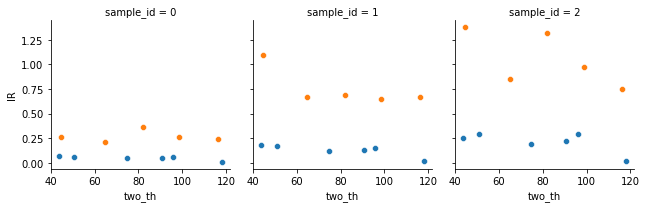

In [13]:
g = sns.FacetGrid(multiple_df,col='sample_id',hue='phases')
g.map(sns.scatterplot,'two_th','IR')

In [41]:
def run_mcmc_multiple(I,R,sigma_I,phases,pfs,sample_ids):

    I = np.array(I)[pfs]
    R = np.array(R)[pfs]
    sigma_I = np.array(sigma_I)[pfs]
    phases = np.array(phases)[pfs]
    sample_ids = np.array(sample_ids)[pfs]
    
    # make sure no phase has <=2 counts
    phase_counts = np.unique(phases, return_counts=True)[1]

    if np.min(phase_counts) <= 2:
        print("Phases with fewer than 3 observations present.")
        return None

    phase_names = phases.copy() # save as backups

    Z = I/R
    unique_phase_names = np.unique(phase_names)
    phases = np.zeros(len(phases),dtype=np.int8)
    
    unique_sample_ids = np.unique(sample_ids)
    
    # create numeric index for each phase
    for ii in range(len(unique_phase_names)):
        phases[phase_names==unique_phase_names[ii]] = int(ii)

    unique_phases = np.unique(phases)
    group_stds = np.zeros((len(unique_phases),len(unique_sample_ids)))
    group_mns = np.zeros((len(unique_phases),len(unique_sample_ids)))

    # standard deviations for each phase
    for ii, up in enumerate(unique_phases):
        for jj, usi in enumerate(unique_sample_ids):
            group_stds[ii,jj] = np.std(Z[ (phases==up) & (sample_ids == usi) ])
            group_mns[ii,jj] = np.mean(Z[ (phases==up) & (sample_ids == usi) ])

    # prior scale and means
    prior_scale = np.mean(group_stds,axis=None)
    phase_prior_mean_centers = np.mean(group_mns,axis=1)
    print("phase prior centers") 
    print(phase_prior_mean_centers)
    sample_prior_mean_centers = np.mean(group_mns,axis=0)
    print("sample prior centers")
    print(sample_prior_mean_centers)

    basic_model = pm.Model() 

    with basic_model:
        
        # Priors
        
        # sigma for sample effect
        sigma_sample = pm.HalfStudentT("sigma_sample",sd=np.std(sample_prior_mean_centers)*2,nu=4)
        
        # sample effect
        sample_effect = pm.Normal("sample_effect",
                                  mu=0,
                                  sd=sigma_sample,
                                  shape=unique_sample_ids.shape[0])
        
        # phase normalized intensity means
        phase_mu = pm.TruncatedNormal("phase_mu", 
                                      mu=phase_prior_mean_centers, 
                                      sd=np.std(phase_prior_mean_centers)*10,
                                      lower=0,
                                      shape=unique_phases.shape[0])
        
        # experimental error (can vary with phase)
        sigma_exp = pm.HalfStudentT("sigma_exp", sd=prior_scale*2, nu=4,shape=len(unique_phases))

        # Likelihood (sampling distribution) of observations
        Y_obs = pm.Normal("Y_obs", 
                          mu=phase_mu[phases] + sample_effect[sample_ids], 
                          sd=sigma_exp[phases],
                          #sd=pm.math.sqrt((1/R**2)*(sigma_I**2) + pm.math.sqr(sigma_exp[phases])), 
                          observed=Z)

        trace = pm.sample(2000, return_inferencedata=False,tune=1000,cores=None,chains=None)
        
        mu_norm = np.apply_along_axis(lambda x: x/np.sum(x),1,trace['phase_mu'])
        
        mu_df = pd.DataFrame(mu_norm,columns=unique_phase_names)
        mu_df = pd.melt(mu_df,value_vars = unique_phase_names,var_name='which_phase',value_name='value')
        

    summary_table = pd.DataFrame({
        'phase':unique_phase_names,
        'PF_Est':np.zeros(len(unique_phase_names)),
        'PF_L95':np.zeros(len(unique_phase_names)),
        'PF_U95':np.zeros(len(unique_phase_names))
    })

    for ii, pn in enumerate(unique_phase_names):

        quantiles = np.quantile(mu_df['value'].loc[mu_df['which_phase']==pn],[.5,.025,.975])
        summary_table.loc[summary_table['phase'] == pn, ['PF_Est','PF_L95','PF_U95']] = quantiles

    return {'mu_df':mu_df,'trace':trace,
            'unique_phase_names':unique_phase_names,
            'summary_table':summary_table}

In [42]:
res = run_mcmc_multiple(I=multiple_df['I'],
                        R=multiple_df['R'],
                        sigma_I=multiple_df['sigma_I'],
                        phases=multiple_df['phases'],
                        pfs=np.array([True]*multiple_df.shape[0]),
                        sample_ids=multiple_df['sample_id'])

phase prior centers
[0.12978122 0.69328836]
sample prior centers
[0.16022471 0.44146056 0.63291909]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_exp, phase_mu, sample_effect, sigma_sample]
Sampling 4 chains: 100%|████████████████████████████████████████████████████| 12000/12000 [00:11<00:00, 1002.18draws/s]
There were 291 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6568633303588546, but should be close to 0.8. Try to increase the number of tuning steps.
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7097546356560106, but should be close to 0.8. Try to increase the number of tuning steps.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.05 for some paramet

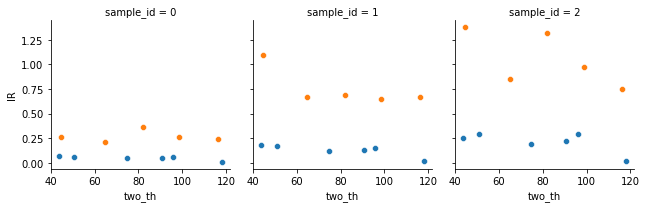

In [16]:
g = sns.FacetGrid(multiple_df,col='sample_id',hue='phases')
g.map(sns.scatterplot,'two_th','IR')

In [21]:
res['summary_table']

,phase,PF_Est,PF_L95,PF_U95
0,austenite-SRM487.cif,0.15889,0.024969,0.253753
1,ferrite-SRM487.cif,0.84111,0.746247,0.975031


<AxesSubplot:xlabel='value', ylabel='Count'>

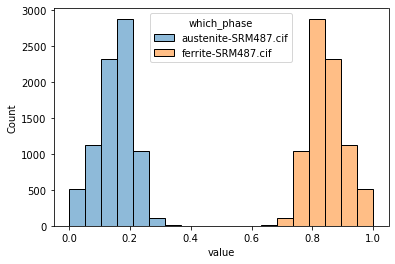

In [39]:
sns.histplot(data=res['mu_df'],x='value',hue='which_phase')

(array([  49.,  260.,  866., 1814., 2330., 1646.,  759.,  223.,   48.,
           5.]),
 array([0.34860419, 0.42719573, 0.50578726, 0.5843788 , 0.66297033,
        0.74156186, 0.8201534 , 0.89874493, 0.97733647, 1.055928  ,
        1.13451953]),
 <BarContainer object of 10 artists>)

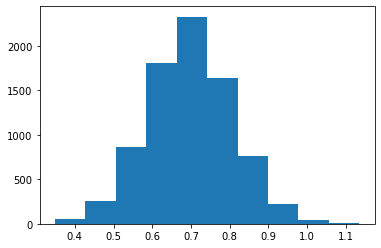

In [19]:
plt.hist(res['trace']['phase_mu'][:,1])

In [20]:
np.mean(multiple_df['IR'].loc[multiple_df['phases'] == np.unique(multiple_df['phases'])[0]])

0.12978122243828658

In [81]:
multiple_df.head()

,I,R,sigma_I,phases,two_th,IR,sig_IR,sample_id
0,17210.289709,261157.488,168.301,austenite-SRM487.cif,43.593,0.065900,0.000644,0
1,7044.282150,122379.402,123.253,austenite-SRM487.cif,50.777,0.057561,0.001007,0
2,4696.534702,70554.804,103.257,austenite-SRM487.cif,74.651,0.066566,0.001464,0
3,4178.107625,80763.209,110.421,austenite-SRM487.cif,90.633,0.051733,0.001367,0
4,1191.115307,23555.357,80.239,austenite-SRM487.cif,95.910,0.050567,0.003406,0
